In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline
plt.rcParams.update({'font.size': 20})

root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'

In [2]:
def print_mem():
    memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
    print('Current memory usage: {:.2f}GB'.format(memory_usage))
print_mem()

Current memory usage: 0.62GB


In [3]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

In [4]:
directory = os.path.join(root_directory,'fly_5','func_0')
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)*1 # this *1 is currently important for some fucking reason
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))
print_mem()


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 62.95 ms
brain shape is x,y,z,t (77, 128, 49, 4731)
Current memory usage: 9.77GB


In [5]:
t0 = time.time()
one_slice = brain[:,:,8,:].reshape(-1, brain.shape[-1])
print(time.time()-t0)

0.6758017539978027


In [61]:
from sklearn.feature_extraction.image import grid_to_graph
connectivity = grid_to_graph(77,128)

In [34]:
connectivity.shape

(9856, 9856)

In [ ]:

t0 = time.time()
model_average = AgglomerativeClustering(n_clusters=2000, memory=clustering_dir, linkage='average')
model_average = model_average.fit(one_slice)
print(time.time()-t0)

In [ ]:
compute_full_tree=True,

In [101]:
clustering_dir = os.path.join(directory, 'super_voxels')

t0 = time.time()
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                memory=clustering_dir,
                                linkage='average')
model = model.fit(one_slice)
print(time.time()-t0)

0.4181673526763916


In [102]:
ii = itertools.count(one_slice.shape[0])
nodes = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

In [103]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [104]:
n_colors = 1000
master_cmap = 'jet'

n_samples = len(nodes) + 1
children_tracker = []

for i in range(len(nodes)):
    left_child = nodes[i]['left']
    right_child = nodes[i]['right']
    num_left_children = 0
    num_right_children = 0
    children_tracker.append({'children': [], 'engulfed_nodes': [i]})
        
    # LEFT CHILD
    if left_child < n_samples:
        children_tracker[-1]['children'].extend([left_child])
    else:
        index = left_child - n_samples
        children_tracker[-1]['children'].extend(children_tracker[index]['children'])
        num_left_children = len(children_tracker[index]['children'])
        
        children_tracker[-1]['engulfed_nodes'].extend(children_tracker[index]['engulfed_nodes'])
    
    # RIGHT CHILD
    if right_child < n_samples:
        children_tracker[-1]['children'].extend([right_child])
    else:
        index = right_child - n_samples
        children_tracker[-1]['children'].extend(children_tracker[index]['children'])
        num_right_children = len(children_tracker[index]['children'])
        
        children_tracker[-1]['engulfed_nodes'].extend(children_tracker[index]['engulfed_nodes'])
        
    # ASSIGN COLOR
    if right_child < n_samples and left_child < n_samples:
        children_tracker[-1]['color'] = random.randint(1, n_colors-1)
    else:
        if num_right_children > num_left_children:
            index = right_child - n_samples
            children_tracker[-1]['color'] = children_tracker[index]['color']
        else:
            index = left_child - n_samples
            children_tracker[-1]['color'] = children_tracker[index]['color']
            
# CREATE BRAIN COLORS OVER TIME

brain_colored = np.zeros((n_samples,n_samples))

for i in range(len(nodes)):
    brain_colored[i+1,:] = brain_colored[i,:]
    brain_colored[i+1,:][children_tracker[i]['children']] = children_tracker[i]['color']
    
brain_colored_toplot = np.reshape(brain_colored, (9856,77,128))
brain_colored_toplot[brain_colored_toplot == 0] = 'nan'
print(brain_colored_toplot.shape)

# CREATE DENDROGRAM COLORS OVER TIME
# here, when a node gets a color, I want all of it's children to get that same color
# need a way to track which nodes were engulfed in other nodes

dendrogram_colored = np.zeros((n_samples,n_samples))

for i in range(len(nodes)):
    dendrogram_colored[i+1,:] = dendrogram_colored[i,:]
    dendrogram_colored[i+1,:][children_tracker[i]['engulfed_nodes']] = children_tracker[i]['color'] # give new node color
    
dendrogram_colored = dendrogram_colored.astype(int)
print(dendrogram_colored.shape)

(9856, 77, 128)
(9856, 9856)


In [95]:
linkages = {'ward_cc': brain_colored_toplot}

In [105]:
linkages['average'] = brain_colored_toplot

In [117]:
grid

In [159]:
77/2

38.5

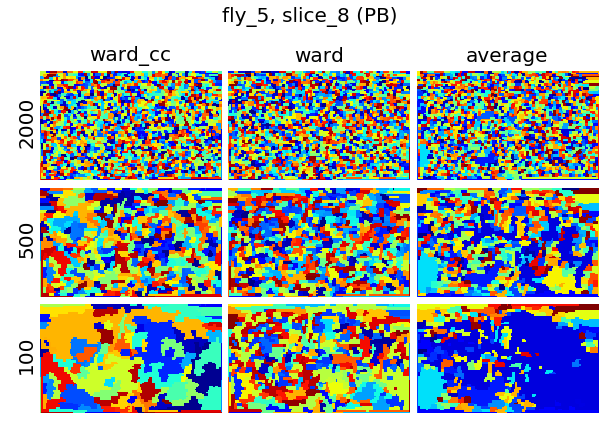

In [170]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.1)
#n_clusters = [500,450,400,350,300,250,200,150,100]
#n_clusters = [int(i) for i in np.linspace(500,4000,16)][::-1]
#n_clusters = [4000,3000,2500,2000,1500,1200,1000,900,800,700,600,500,400,300,200,100,80,60,40,20]
n_clusters = [2000,500,100]
plot_num=-1
for j,n_cluster in enumerate(n_clusters):
    for i,link in enumerate(linkages):
        plot_num += 1        
        grid[plot_num].imshow(linkages[link][n_samples-n_cluster,:,:],vmin=0,vmax=n_colors,cmap=master_cmap)
        grid[plot_num].axis('off')
        if plot_num in [0,1,2]:
            grid[plot_num].set_title('{}'.format(link),
                              fontsize=20,
                              x=.5,y=1,
                              horizontalalignment='center',
                              verticalalignment='bottom')
        if plot_num in [0,3,6]:
            grid[plot_num].text(s='{}'.format(n_cluster),
                              fontsize=20,
                              x=-3,y=35,
                              horizontalalignment='right',
                              verticalalignment='center',
                               rotation=90)

plt.suptitle(x=.5,y=.83,t='fly_5, slice_8 (PB)', fontsize=20)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
#plt.savefig(fname,dpi=300,bbox_inches='tight')

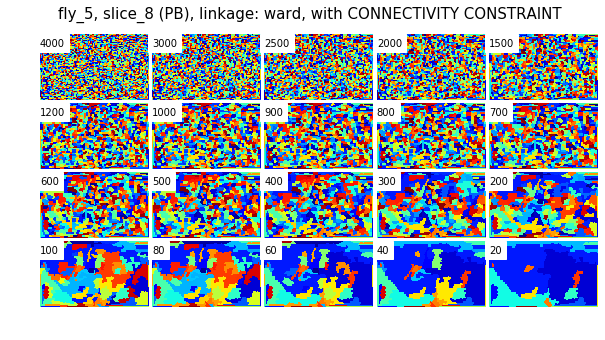

In [89]:
linkage='ward'

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.05)
#n_clusters = [500,450,400,350,300,250,200,150,100]
n_clusters = [int(i) for i in np.linspace(500,4000,16)][::-1]

n_clusters = [4000,3000,2500,2000,1500,1200,1000,900,800,700,600,500,400,300,200,100,80,60,40,20]

for i,n_cluster in enumerate(n_clusters):
    grid[i].imshow(brain_colored_toplot[n_samples-n_cluster,:,:],vmin=0,vmax=n_colors,cmap=master_cmap)
    grid[i].axis('off')
    grid[i].set_title('{}'.format(n_cluster),
                      fontsize=10,
                      x=0,y=.85,
                      backgroundcolor='white',
                      horizontalalignment='left',
                      verticalalignment='top')
plt.suptitle(x=.5,y=.73,t='fly_5, slice_8 (PB), linkage: {}, with CONNECTIVITY CONSTRAINT'.format(linkage),fontsize=15)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [ ]:
clustering_dir = os.path.join(directory, 'super_voxels')

t0 = time.time()
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                memory=clustering_dir,
                                linkage='ward',
                                connectivity=connectivity)
model = model.fit(one_slice)
print(time.time()-t0)

In [ ]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.05)
#n_clusters = [500,450,400,350,300,250,200,150,100]
#n_clusters = [int(i) for i in np.linspace(500,4000,16)][::-1]
#n_clusters = [4000,3000,2500,2000,1500,1200,1000,900,800,700,600,500,400,300,200,100,80,60,40,20]

for i,n_cluster in enumerate(n_clusters):
    grid[i].imshow(brain_colored_toplot[n_samples-n_cluster,:,:],vmin=0,vmax=n_colors,cmap=master_cmap)
    grid[i].axis('off')
    grid[i].set_title('{}'.format(n_cluster),
                      fontsize=10,
                      x=0,y=.85,
                      backgroundcolor='white',
                      horizontalalignment='left',
                      verticalalignment='top')
plt.suptitle(x=.5,y=.73,t='fly_5, slice_8 (PB), linkage: {}'.format(linkage),fontsize=15)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
#plt.savefig(fname,dpi=300,bbox_inches='tight')